In [132]:
# installation de findspark
!pip install findspark

In [133]:
# Installation de Xgboost
!pip install xgboost


In [134]:
# installation de scikit-learn
!pip install scikit-learn

In [135]:
# installation de pyspark
!pip install pyspark

In [136]:
# import de findspark
import findspark
findspark.init

<function findspark.init(spark_home=None, python_path=None, edit_rc=False, edit_profile=False)>

In [137]:
# import pyspark
import pyspark
from pyspark.sql import SparkSession

In [138]:
spark = SparkSession.builder.appName('Data Analysis').getOrCreate()


In [139]:
#connaitre le nombre de processeurs fonctionnels
cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [218]:
#importation des librairies
import pyspark
from pyspark.sql import SparkSession

#module pour le preprocessing
from pyspark.sql.functions import*
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer

# training et evaluation
from  pyspark.ml.regression import *
from  pyspark.ml.evaluation import *
from  pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import seaborn as sns
import matplotlib.pyplot as plt
import pyspark.pandas as ps


In [219]:
# importation du dataset
orange = spark.read.csv('orange.csv',inferSchema=True,header=True)
orange.show(5)

+---------+----------+----------------+------------+--------------+------------------+--------------+------------+------------+---------------+-------------+-------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|       Color|     Variety|Blemishes (Y/N)|Quality (1-5)|Color_Encoded|
+---------+----------+----------------+------------+--------------+------------------+--------------+------------+------------+---------------+-------------+-------------+
|      7.5|       180|            12.0|         3.2|           2.0|                10|           4.0|      Orange|    Valencia|              N|          4.0|            2|
|      8.2|       220|            10.5|         3.4|           3.0|                14|           4.5| Deep Orange|       Navel|              N|          4.5|            0|
|      6.8|       150|            14.0|         3.0|           1.0|                 7|           5.0|Light Orange|   Cara Cara|             

In [220]:
# shape
print(orange.count(),len(orange.columns))

241 12


In [221]:
#liste des colonnes avec les types
orange.printSchema()

root
 |-- Size (cm): double (nullable = true)
 |-- Weight (g): integer (nullable = true)
 |-- Brix (Sweetness): double (nullable = true)
 |-- pH (Acidity): double (nullable = true)
 |-- Softness (1-5): double (nullable = true)
 |-- HarvestTime (days): integer (nullable = true)
 |-- Ripeness (1-5): double (nullable = true)
 |-- Color: string (nullable = true)
 |-- Variety: string (nullable = true)
 |-- Blemishes (Y/N): string (nullable = true)
 |-- Quality (1-5): double (nullable = true)
 |-- Color_Encoded: integer (nullable = true)



In [222]:
# affichage du nom des colonnes
orange.columns

['Size (cm)',
 'Weight (g)',
 'Brix (Sweetness)',
 'pH (Acidity)',
 'Softness (1-5)',
 'HarvestTime (days)',
 'Ripeness (1-5)',
 'Color',
 'Variety',
 'Blemishes (Y/N)',
 'Quality (1-5)',
 'Color_Encoded']

In [223]:
#Vérifions tout d'abord les valeurs nulles s'il y en a
from pyspark.sql.functions import col, isnan, when, count #ici nous importons la librairie des différentes fonctions dont nous aurons besoin
orange.select([count(when(isnan(c) | col(c).isNull(),c)).alias(c) for c in orange.columns]).show()

+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Color|Variety|Blemishes (Y/N)|Quality (1-5)|Color_Encoded|
+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+
|        0|         0|               0|           0|             0|                 0|             0|    0|      0|              0|            0|            0|
+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+



In [224]:
orange.limit(5).toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0,2
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5,0
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0,1
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5,3
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5,2


In [225]:
orange.select('Size (cm)','Weight (g)','Brix (Sweetness)', 'pH (Acidity)','Softness (1-5)','HarvestTime (days)','Ripeness (1-5)','Quality (1-5)').summary('count','min','max','25%','75%').toPandas()

,summary,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Quality (1-5)
0,count,241,241,241,241,241,241,241,241
1,min,6.0,100,5.5,2.8,1.0,4,1.0,1.0
2,max,10.0,300,16.0,4.4,5.0,25,5.0,5.0
3,25%,6.9,155,8.5,3.2,2.0,11,3.0,3.0
4,75%,8.7,252,13.4,3.8,4.0,20,4.5,4.5


# Verification des outliers

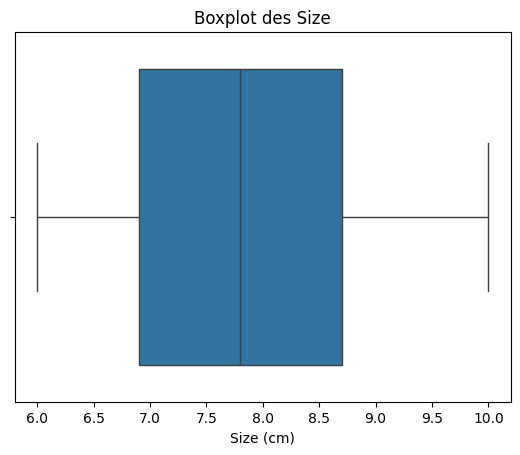

In [226]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Size (cm)', data=orange_pandas)
plt.title("Boxplot des Size")
plt.show()

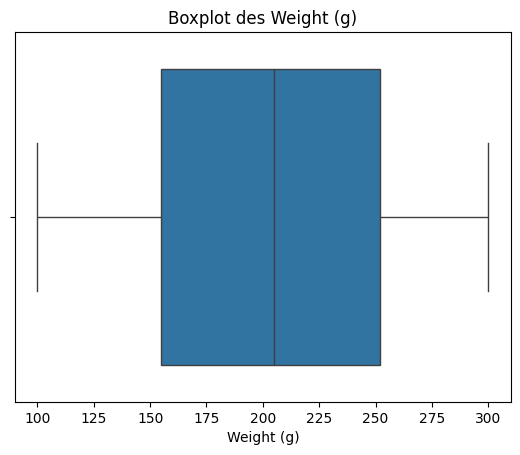

In [227]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Weight (g)', data=orange_pandas)
plt.title("Boxplot des Weight (g)")
plt.show()

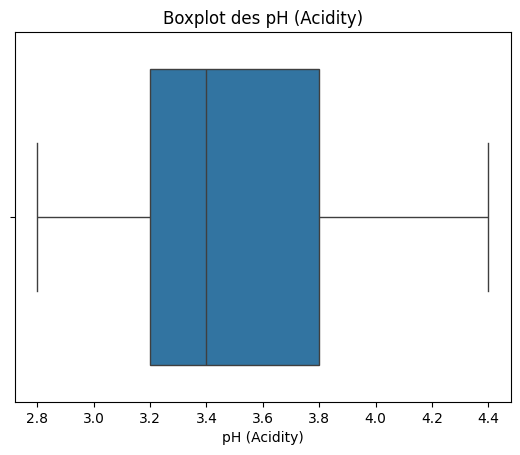

In [228]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='pH (Acidity)', data=orange_pandas)
plt.title("Boxplot des pH (Acidity)")
plt.show()

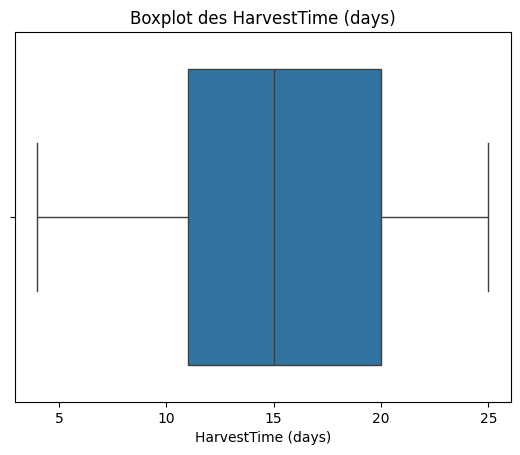

In [229]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='HarvestTime (days)', data=orange_pandas)
plt.title("Boxplot des HarvestTime (days)")
plt.show()

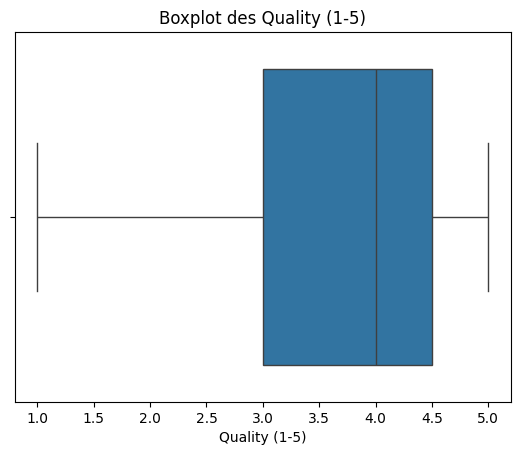

In [230]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Quality (1-5)', data=orange_pandas)
plt.title("Boxplot des Quality (1-5)")
plt.show()

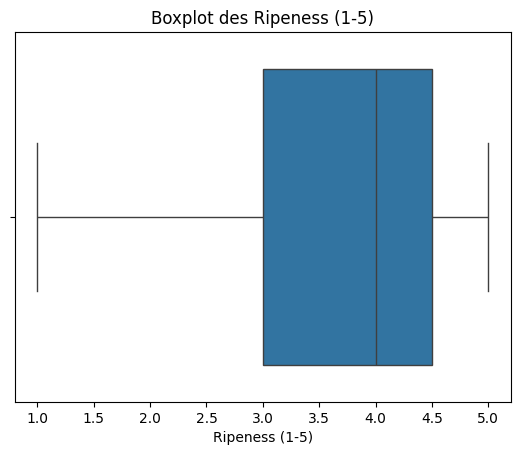

In [231]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Ripeness (1-5)', data=orange_pandas)
plt.title("Boxplot des Ripeness (1-5)")
plt.show()

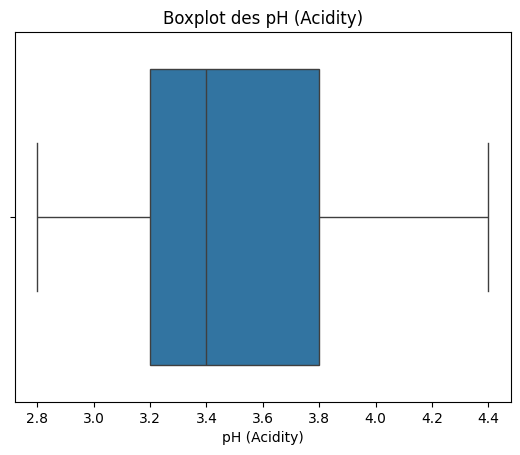

In [232]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='pH (Acidity)', data=orange_pandas)
plt.title("Boxplot des pH (Acidity)")
plt.show()

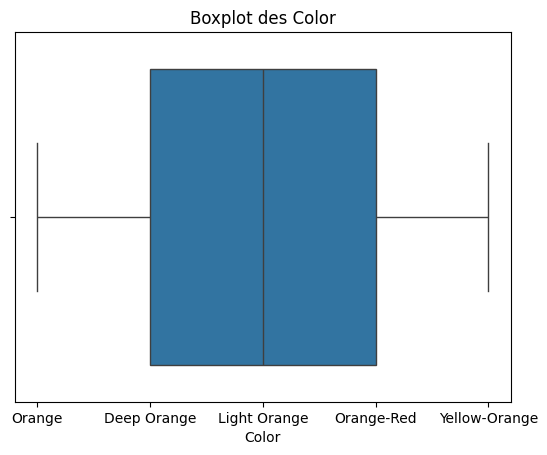

In [233]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Color', data=orange_pandas)
plt.title("Boxplot des Color")
plt.show()

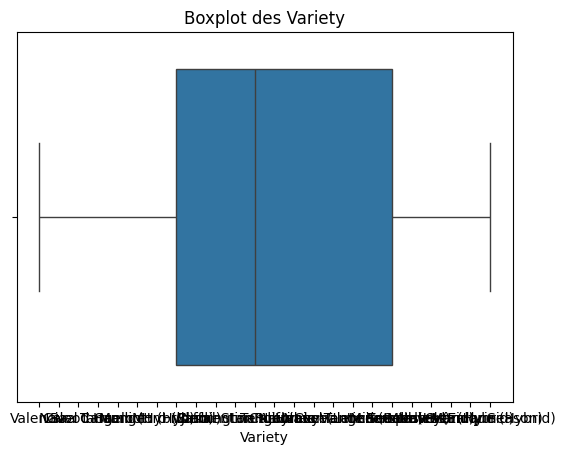

In [234]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Variety', data=orange_pandas)
plt.title("Boxplot des Variety")
plt.show()

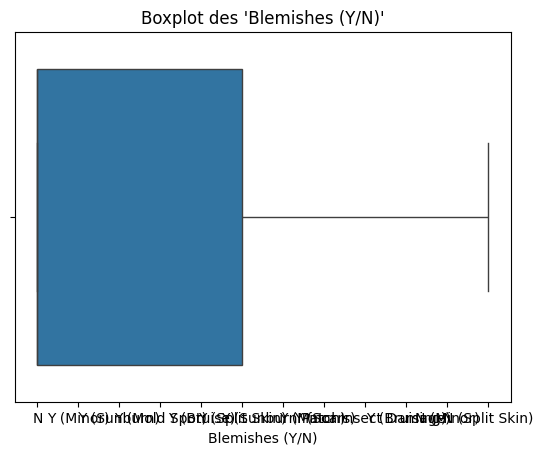

In [235]:
# Convertir l'objet DataFrame de pyspark en un DataFrame de pandas
orange_pandas = orange.toPandas()

# Utiliser la fonction boxplot avec le DataFrame de pandas converti
sns.boxplot(x='Blemishes (Y/N)', data=orange_pandas)
plt.title("Boxplot des 'Blemishes (Y/N)'")
plt.show()

In [236]:
# Compter les doublons en utilisant groupBy et count
duplicates = orange.groupBy(orange.columns).count().filter(col('count') > 1)

# Afficher le nombre de lignes dupliquées
duplicates.count()

0

/usr/local/lib/python3.10/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: `to_pandas` loads all data into the driver's memory. It should only be used if the resulting pandas DataFrame is expected to be small.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


<Axes: xlabel='Quality (1-5)', ylabel='Count'>

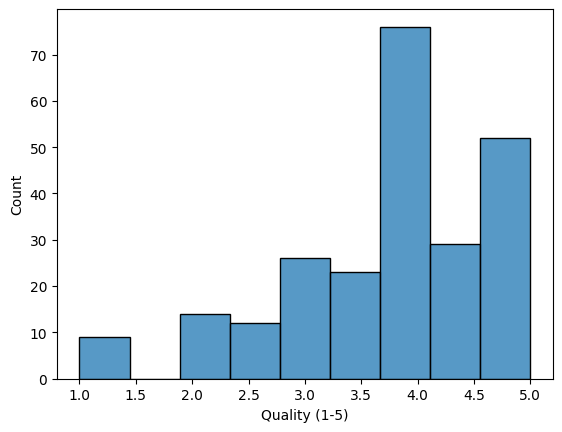

In [237]:
# Convert the PySpark DataFrame to a pyspark.pandas DataFrame
orange = ps.DataFrame(orange)  # Use ps.DataFrame to create a pyspark.pandas DataFrame

# Now you can use the to_pandas() method
orange = orange.to_pandas()

sns.histplot(x='Quality (1-5)', data=orange)

<Axes: xlabel='Color', ylabel='Count'>

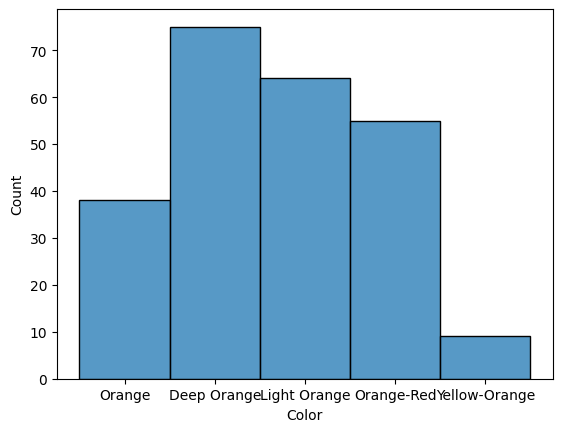

In [238]:
#pour avoir l'histogramme de Color
sns.histplot(x = 'Color', data = orange)


<Axes: xlabel='Size (cm)', ylabel='Count'>

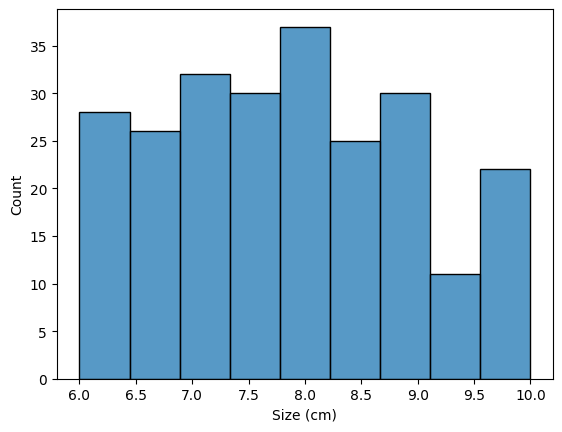

In [239]:
#pour avoir l'histogramme de Size (cm)
sns.histplot(x = 'Size (cm)', data = orange)

<Axes: xlabel='Weight (g)', ylabel='Count'>

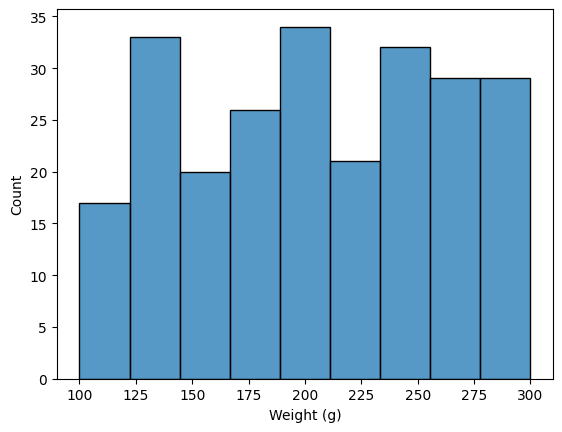

In [240]:
#pour avoir l'histogramme de Weight (g)
sns.histplot(x = 'Weight (g)', data = orange)

<Axes: xlabel='Size (cm)', ylabel='Weight (g)'>

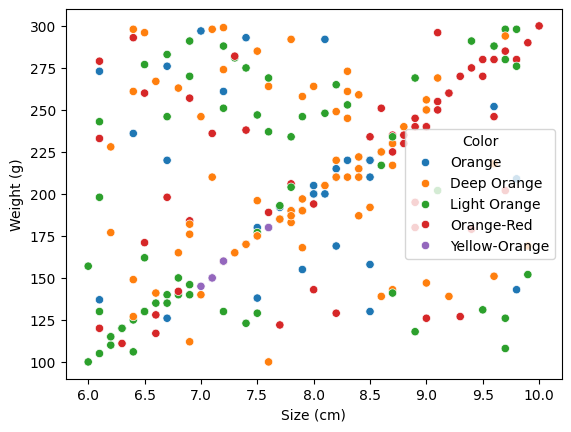

In [241]:
# histogramme
sns.scatterplot(x = 'Size (cm)', y = 'Weight (g)', data = orange, hue = 'Color') # fonction pour obtenir un nuage de points

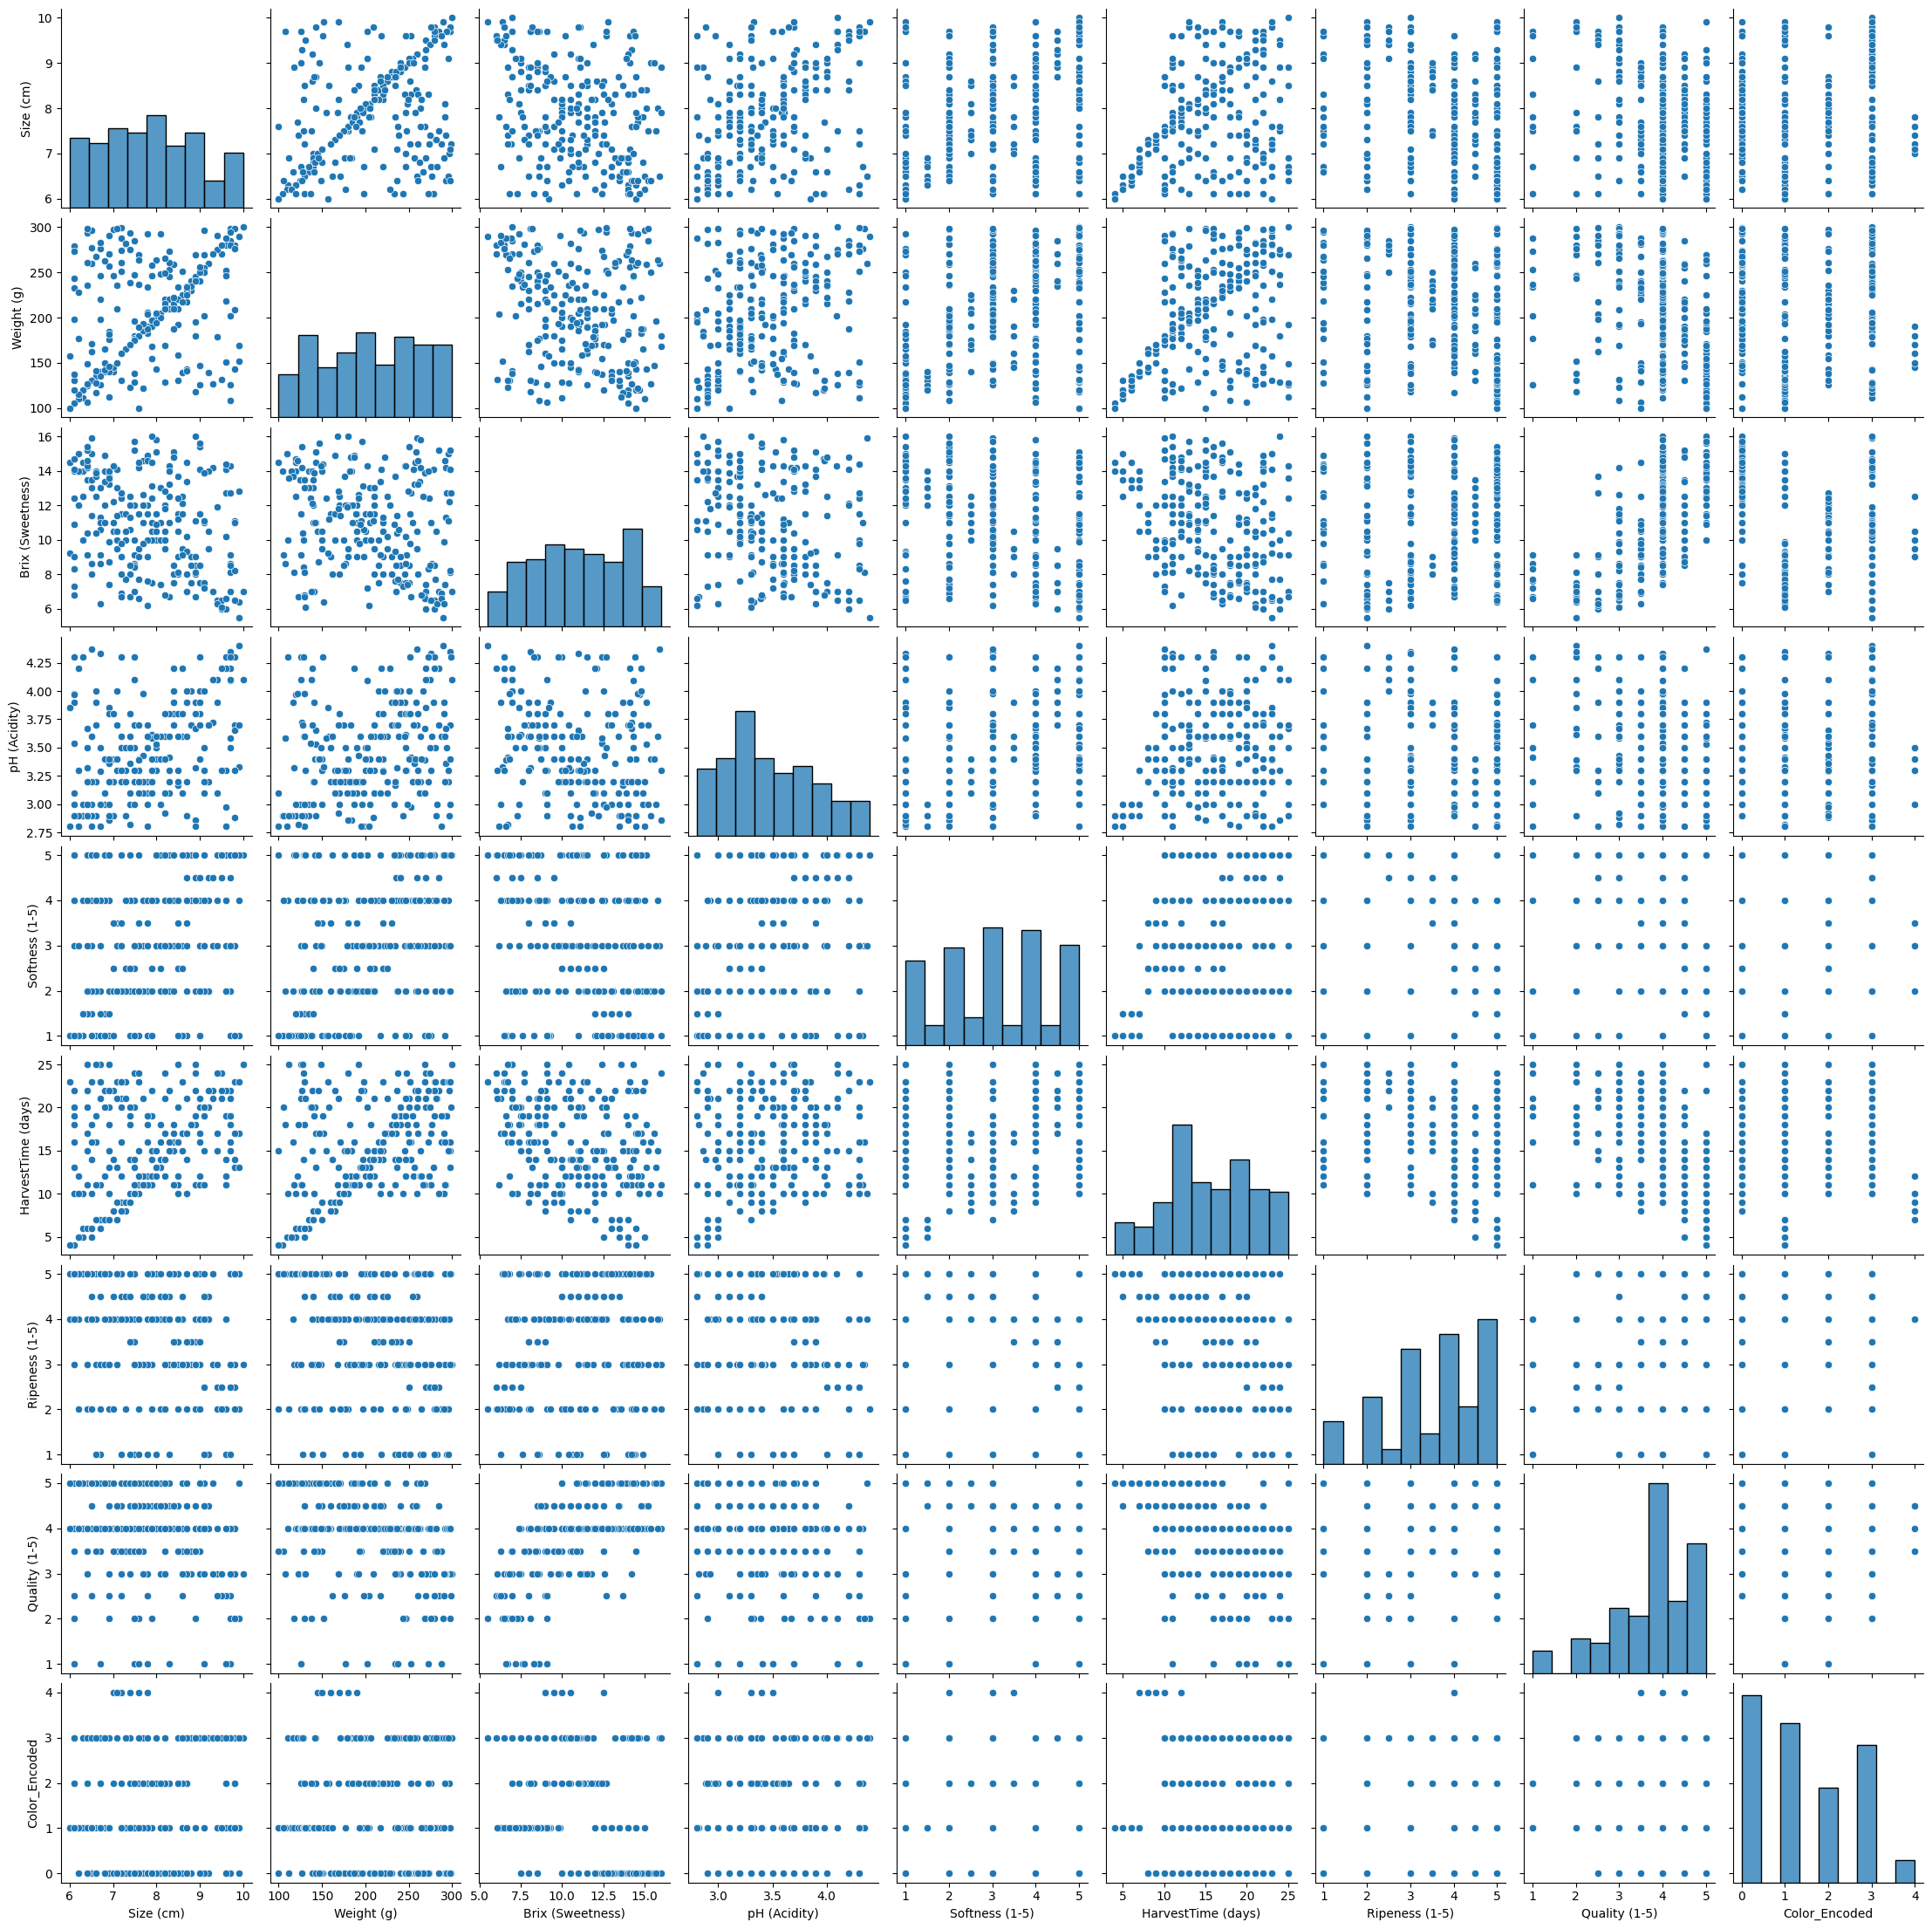

In [242]:
# pairplot
sns.pairplot(data = orange)

# Select

In [243]:
#Nous allons utiliser cette commande pour compter les valeurs unique dans la colonne Color
value_counts = orange.groupby('Color').count()


In [244]:
#Affichage du nombre de couleur
value_counts.head(5)

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded
Color,,,,,,,,,,,
Deep Orange,75,75,75,75,75,75,75,75,75,75,75
Light Orange,64,64,64,64,64,64,64,64,64,64,64
Orange,38,38,38,38,38,38,38,38,38,38,38
Orange-Red,55,55,55,55,55,55,55,55,55,55,55
Yellow-Orange,9,9,9,9,9,9,9,9,9,9,9


In [245]:
# affichage des couleur Deep Orange et orange
orange[orange.Color.isin(['Deep Orange','Orange'])].head(4)


,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0,2
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5,0
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5,2
5,6.7,126,9.1,3.0,2.0,25,2.0,Orange,Navel,N,1.0,2


In [246]:
#Nous allons utiliser cette commande pour compter les valeurs unique dans la colonne Country
value_counts = orange.groupby('Quality (1-5)').count()

In [247]:
#Affichage
value_counts.head(4)

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Color_Encoded
Quality (1-5),,,,,,,,,,,
1.0,9,9,9,9,9,9,9,9,9,9,9
2.0,14,14,14,14,14,14,14,14,14,14,14
2.5,12,12,12,12,12,12,12,12,12,12,12
3.0,26,26,26,26,26,26,26,26,26,26,26


In [248]:
# Regroupement de size et weight

orange[['Size (cm)','Weight (g)']].sort_values('Weight (g)').head(4)

,Size (cm),Weight (g)
226,7.6,100
71,6.0,100
51,6.1,105
161,6.4,106


In [249]:
# Weight (g) Superieur a 50
orange[orange['Weight (g)'] >= 50].head(5)


,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0,2
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5,0
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0,1
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5,3
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5,2


In [250]:
# afficahe de la taille > 50 et la couleur egale orange
orange[(orange['Weight (g)']>=50 ) & (orange.Color=='Orange')]

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded
0,7.5,180,12.0,3.20,2.0,10,4.0,Orange,Valencia,N,4.0,2
4,8.5,210,11.5,3.30,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5,2
5,6.7,126,9.1,3.00,2.0,25,2.0,Orange,Navel,N,1.0,2
9,7.8,190,12.0,3.10,2.0,11,4.5,Orange,Jaffa,N,5.0,2
12,8.0,200,10.0,3.50,3.0,13,4.0,Orange,Clementine,N,4.5,2
16,8.7,230,8.0,3.90,3.5,17,3.5,Orange,Ambiance,Y (Bruise),3.5,2
22,7.6,180,9.0,3.30,3.0,11,4.0,Orange,California Valencia,N,4.5,2
24,7.9,190,10.5,3.10,2.5,12,4.0,Orange,Honey Tangerine,N,4.5,2
30,8.3,220,11.0,3.30,3.0,15,4.0,Orange,Hamlin,N,4.5,2
35,8.6,225,9.5,3.60,3.0,17,4.0,Orange,Midsweet (Hybrid),Y (Scars),3.5,2


# PRE-**PROCESSING**

In [251]:
# savoir le type de mon dataset
type(orange)

pandas.core.frame.DataFrame

In [252]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, when, isnan, col

# conversion
spark = SparkSession.builder.getOrCreate()
spark_df = spark.createDataFrame(orange)  # Create PySpark DataFrame

# verification des nan - Use PySpark syntax
spark_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_df.columns]).show()


+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Color|Variety|Blemishes (Y/N)|Quality (1-5)|Color_Encoded|
+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+
|        0|         0|               0|           0|             0|                 0|             0|    0|      0|              0|            0|            0|
+---------+----------+----------------+------------+--------------+------------------+--------------+-----+-------+---------------+-------------+-------------+



# encodage de Color

In [253]:
# encodage de la colonne Color
# 1-indexation
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='Color',outputCol='Colores').fit(spark_df)
indexed = indexer.transform(spark_df)
indexed.toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded,Colores
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0,2,3.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5,0,0.0
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0,1,1.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5,3,2.0
4,8.5,210,11.5,3.3,2.5,12,5.0,Orange,Hamlin,Y (Minor),4.5,2,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8.0,194,10.9,3.6,5.0,13,1.0,Orange-Red,Tangerine,Y (Scars),5.0,3,2.0
237,7.4,275,8.5,3.5,5.0,20,5.0,Light Orange,Minneola (Hybrid),N,4.0,1,1.0
238,7.5,196,15.7,3.0,3.0,13,3.0,Deep Orange,Temple,Y (Minor Insect Damage),5.0,0,0.0
239,7.2,251,9.8,4.3,3.0,23,1.0,Light Orange,Moro (Blood),Y (Minor Insect Damage),3.0,1,1.0


In [254]:
# 2 one hot encoder
# changement de renommage de la colonne
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol ='Colores', outputCol = 'new_colore').fit(indexed)
orange = encoder.transform(indexed)
orange.limit(4).toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Color,Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded,Colores,new_colore
0,7.5,180,12.0,3.2,2.0,10,4.0,Orange,Valencia,N,4.0,2,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,8.2,220,10.5,3.4,3.0,14,4.5,Deep Orange,Navel,N,4.5,0,0.0,"(1.0, 0.0, 0.0, 0.0)"
2,6.8,150,14.0,3.0,1.0,7,5.0,Light Orange,Cara Cara,N,5.0,1,1.0,"(0.0, 1.0, 0.0, 0.0)"
3,9.0,250,8.5,3.8,4.0,21,3.5,Orange-Red,Blood Orange,N,3.5,3,2.0,"(0.0, 0.0, 1.0, 0.0)"


In [255]:
# Suppresion de l'ancienne colone Orange
orange = orange.drop('Colores','Color')
orange.show()

+---------+----------+----------------+------------+--------------+------------------+--------------+----------------+---------------+-------------+-------------+-------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|         Variety|Blemishes (Y/N)|Quality (1-5)|Color_Encoded|   new_colore|
+---------+----------+----------------+------------+--------------+------------------+--------------+----------------+---------------+-------------+-------------+-------------+
|      7.5|       180|            12.0|         3.2|           2.0|                10|           4.0|        Valencia|              N|          4.0|            2|(4,[3],[1.0])|
|      8.2|       220|            10.5|         3.4|           3.0|                14|           4.5|           Navel|              N|          4.5|            0|(4,[0],[1.0])|
|      6.8|       150|            14.0|         3.0|           1.0|                 7|           5.0|       Cara Ca

# encodage de Variety

In [256]:
# encodage
# 1-indexation
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='Variety',outputCol='Variet').fit(orange)
indexed = indexer.transform(orange)
indexed.toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded,new_colore,Variet
0,7.5,180,12.0,3.2,2.0,10,4.0,Valencia,N,4.0,2,"(0.0, 0.0, 0.0, 1.0)",13.0
1,8.2,220,10.5,3.4,3.0,14,4.5,Navel,N,4.5,0,"(1.0, 0.0, 0.0, 0.0)",4.0
2,6.8,150,14.0,3.0,1.0,7,5.0,Cara Cara,N,5.0,1,"(0.0, 1.0, 0.0, 0.0)",0.0
3,9.0,250,8.5,3.8,4.0,21,3.5,Blood Orange,N,3.5,3,"(0.0, 0.0, 1.0, 0.0)",21.0
4,8.5,210,11.5,3.3,2.5,12,5.0,Hamlin,Y (Minor),4.5,2,"(0.0, 0.0, 0.0, 1.0)",16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8.0,194,10.9,3.6,5.0,13,1.0,Tangerine,Y (Scars),5.0,3,"(0.0, 0.0, 1.0, 0.0)",6.0
237,7.4,275,8.5,3.5,5.0,20,5.0,Minneola (Hybrid),N,4.0,1,"(0.0, 1.0, 0.0, 0.0)",10.0
238,7.5,196,15.7,3.0,3.0,13,3.0,Temple,Y (Minor Insect Damage),5.0,0,"(1.0, 0.0, 0.0, 0.0)",2.0
239,7.2,251,9.8,4.3,3.0,23,1.0,Moro (Blood),Y (Minor Insect Damage),3.0,1,"(0.0, 1.0, 0.0, 0.0)",3.0


In [257]:
# 2 one hot encoder
# renommage des colonnes
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol ='Variet', outputCol = 'new_Variety').fit(indexed)
orange = encoder.transform(indexed)
orange.limit(4).toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Variety,Blemishes (Y/N),Quality (1-5),Color_Encoded,new_colore,Variet,new_Variety
0,7.5,180,12.0,3.2,2.0,10,4.0,Valencia,N,4.0,2,"(0.0, 0.0, 0.0, 1.0)",13.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8.2,220,10.5,3.4,3.0,14,4.5,Navel,N,4.5,0,"(1.0, 0.0, 0.0, 0.0)",4.0,"(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6.8,150,14.0,3.0,1.0,7,5.0,Cara Cara,N,5.0,1,"(0.0, 1.0, 0.0, 0.0)",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9.0,250,8.5,3.8,4.0,21,3.5,Blood Orange,N,3.5,3,"(0.0, 0.0, 1.0, 0.0)",21.0,"(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [258]:
# Suppresion de l'ancienn colonne Variety
orange = orange.drop('Variety','Variet')
orange.show()

+---------+----------+----------------+------------+--------------+------------------+--------------+---------------+-------------+-------------+-------------+---------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Blemishes (Y/N)|Quality (1-5)|Color_Encoded|   new_colore|    new_Variety|
+---------+----------+----------------+------------+--------------+------------------+--------------+---------------+-------------+-------------+-------------+---------------+
|      7.5|       180|            12.0|         3.2|           2.0|                10|           4.0|              N|          4.0|            2|(4,[3],[1.0])|(23,[13],[1.0])|
|      8.2|       220|            10.5|         3.4|           3.0|                14|           4.5|              N|          4.5|            0|(4,[0],[1.0])| (23,[4],[1.0])|
|      6.8|       150|            14.0|         3.0|           1.0|                 7|           5.0|              N|   

# encodage de Blemishes

In [259]:
# encodage
# 1-indexation
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCol='Blemishes (Y/N)',outputCol='Blemishes').fit(orange)
indexed = indexer.transform(orange)
indexed.toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Blemishes (Y/N),Quality (1-5),Color_Encoded,new_colore,new_Variety,Blemishes
0,7.5,180,12.0,3.2,2.0,10,4.0,N,4.0,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
1,8.2,220,10.5,3.4,3.0,14,4.5,N,4.5,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
2,6.8,150,14.0,3.0,1.0,7,5.0,N,5.0,1,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
3,9.0,250,8.5,3.8,4.0,21,3.5,N,3.5,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
4,8.5,210,11.5,3.3,2.5,12,5.0,Y (Minor),4.5,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,8.0,194,10.9,3.6,5.0,13,1.0,Y (Scars),5.0,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",2.0
237,7.4,275,8.5,3.5,5.0,20,5.0,N,4.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0
238,7.5,196,15.7,3.0,3.0,13,3.0,Y (Minor Insect Damage),5.0,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.0
239,7.2,251,9.8,4.3,3.0,23,1.0,Y (Minor Insect Damage),3.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",7.0


In [260]:
# 2 one hot encoder
# renommage de la colonne
from pyspark.ml.feature import OneHotEncoder
encoder = OneHotEncoder(inputCol ='Blemishes', outputCol = 'new_Blemishes').fit(indexed)
orange = encoder.transform(indexed)
orange.limit(4).toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Blemishes (Y/N),Quality (1-5),Color_Encoded,new_colore,new_Variety,Blemishes,new_Blemishes
0,7.5,180,12.0,3.2,2.0,10,4.0,N,4.0,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8.2,220,10.5,3.4,3.0,14,4.5,N,4.5,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6.8,150,14.0,3.0,1.0,7,5.0,N,5.0,1,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9.0,250,8.5,3.8,4.0,21,3.5,N,3.5,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [261]:
# Suppresion de la colonne
orange = orange.drop('Blemishes','Blemishes (Y/N)')
orange.show()

+---------+----------+----------------+------------+--------------+------------------+--------------+-------------+-------------+-------------+---------------+--------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Quality (1-5)|Color_Encoded|   new_colore|    new_Variety| new_Blemishes|
+---------+----------+----------------+------------+--------------+------------------+--------------+-------------+-------------+-------------+---------------+--------------+
|      7.5|       180|            12.0|         3.2|           2.0|                10|           4.0|          4.0|            2|(4,[3],[1.0])|(23,[13],[1.0])|(11,[0],[1.0])|
|      8.2|       220|            10.5|         3.4|           3.0|                14|           4.5|          4.5|            0|(4,[0],[1.0])| (23,[4],[1.0])|(11,[0],[1.0])|
|      6.8|       150|            14.0|         3.0|           1.0|                 7|           5.0|          5.0|          

# Renommage des colonnes des noms des colonnes

In [262]:
# Renommer la colonne
orange = orange.withColumnRenamed('new_colore', 'Color')

# Renommer la colonne
orange = orange.withColumnRenamed('new_Variety', 'Variety')

# Renommer la colonne
orange = orange.withColumnRenamed('new_Blemishes', 'Blemishes')

# Renommer la colonne
orange = orange.withColumnRenamed('Quality (1-5)', 'Quality')


# Afficher le DataFrame Pandas
orange.toPandas()

,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Quality,Color_Encoded,Color,Variety,Blemishes
0,7.5,180,12.0,3.2,2.0,10,4.0,4.0,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,8.2,220,10.5,3.4,3.0,14,4.5,4.5,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,6.8,150,14.0,3.0,1.0,7,5.0,5.0,1,"(0.0, 1.0, 0.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9.0,250,8.5,3.8,4.0,21,3.5,3.5,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,8.5,210,11.5,3.3,2.5,12,5.0,4.5,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
236,8.0,194,10.9,3.6,5.0,13,1.0,5.0,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
237,7.4,275,8.5,3.5,5.0,20,5.0,4.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
238,7.5,196,15.7,3.0,3.0,13,3.0,5.0,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
239,7.2,251,9.8,4.3,3.0,23,1.0,3.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."


# split

In [263]:
# standardise
# train test split
train,test = orange.randomSplit([0.7,0.3],seed = 2018)
print ('Training Dataset count:'+str(train.count()))
print ('Training Dataset count:'+str(test.count()))

Training Dataset count:173
Training Dataset count:68


In [264]:
# rassembler des features
col_to_scale=['Size (cm)',
 'Weight (g)',
 'Brix (Sweetness)',
 'pH (Acidity)',
 'Softness (1-5)',
 'HarvestTime (days)',
 'Ripeness (1-5)',
 'Color',
 'Variety',
  'Blemishes']

In [265]:
# changement de variable et affichage
s_assembler = VectorAssembler(inputCols = col_to_scale,outputCol='colonne_ass')
output = s_assembler.transform(train)
output.toPandas()


,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),Quality,Color_Encoded,Color,Variety,Blemishes,colonne_ass
0,6.1,105,14.0,2.90,1.0,4,5.0,5.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 105.0, 14.0, 2.9, 1.0, 4.0, 5.0, 0.0, 1...."
1,6.1,120,14.7,3.97,5.0,10,5.0,4.0,3,"(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(6.1, 120.0, 14.7, 3.97, 5.0, 10.0, 5.0, 0.0, ..."
2,6.1,130,6.8,3.98,3.0,18,5.0,2.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 130.0, 6.8, 3.98, 3.0, 18.0, 5.0, 0.0, 1..."
3,6.1,137,12.4,3.54,4.0,20,5.0,4.0,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 137.0, 12.4, 3.54, 4.0, 20.0, 5.0, 0.0, ..."
4,6.1,279,14.1,3.90,4.0,13,4.0,4.0,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(6.1, 279.0, 14.1, 3.9, 4.0, 13.0, 4.0, 0.0, 0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,9.6,288,6.6,2.80,2.0,19,2.0,1.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.6, 288.0, 6.6, 2.8, 2.0, 19.0, 2.0, 0.0, 1...."
169,9.7,126,9.1,4.10,1.0,21,3.0,1.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.7, 126.0, 9.1, 4.1, 1.0, 21.0, 3.0, 0.0, 1...."
170,9.7,280,8.5,4.30,3.0,19,1.0,3.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.7, 280.0, 8.5, 4.3, 3.0, 19.0, 1.0, 0.0, 1...."
171,9.7,294,12.7,3.50,3.0,19,1.0,4.0,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(9.7, 294.0, 12.7, 3.5, 3.0, 19.0, 1.0, 1.0, 0..."


# standardise

In [266]:
from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol='colonne_ass', outputCol='scaled_features',withMean = True, withStd=True)

In [267]:
# fit
scaler_model = scaler.fit(output)
scaled_data = scaler_model.transform(output)
scaled_data.show()

+---------+----------+----------------+------------+--------------+------------------+--------------+-------+-------------+-------------+---------------+--------------+--------------------+--------------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Quality|Color_Encoded|        Color|        Variety|     Blemishes|         colonne_ass|     scaled_features|
+---------+----------+----------------+------------+--------------+------------------+--------------+-------+-------------+-------------+---------------+--------------+--------------------+--------------------+
|      6.1|       105|            14.0|         2.9|           1.0|                 4|           5.0|    5.0|            1|(4,[1],[1.0])| (23,[9],[1.0])|(11,[0],[1.0])|(45,[0,1,2,3,4,5,...|[-1.6406641119182...|
|      6.1|       120|            14.7|        3.97|           5.0|                10|           5.0|    4.0|            3|(4,[2],[1.0])| (23,[0],[1.0])|(11

In [268]:
# fit
scaler_model = scaler.fit(output)
scaled_data = scaler_model.transform(output)
scaled_data.show()

+---------+----------+----------------+------------+--------------+------------------+--------------+-------+-------------+-------------+---------------+--------------+--------------------+--------------------+
|Size (cm)|Weight (g)|Brix (Sweetness)|pH (Acidity)|Softness (1-5)|HarvestTime (days)|Ripeness (1-5)|Quality|Color_Encoded|        Color|        Variety|     Blemishes|         colonne_ass|     scaled_features|
+---------+----------+----------------+------------+--------------+------------------+--------------+-------+-------------+-------------+---------------+--------------+--------------------+--------------------+
|      6.1|       105|            14.0|         2.9|           1.0|                 4|           5.0|    5.0|            1|(4,[1],[1.0])| (23,[9],[1.0])|(11,[0],[1.0])|(45,[0,1,2,3,4,5,...|[-1.6406641119182...|
|      6.1|       120|            14.7|        3.97|           5.0|                10|           5.0|    4.0|            3|(4,[2],[1.0])| (23,[0],[1.0])|(11

In [269]:
# Renommer la colonne 'median_house_value' en 'label'
scaled_data = scaled_data.withColumnRenamed('Quality', 'label')

# Afficher le DataFrame Pandas
scaled_data.toPandas()


,Size (cm),Weight (g),Brix (Sweetness),pH (Acidity),Softness (1-5),HarvestTime (days),Ripeness (1-5),label,Color_Encoded,Color,Variety,Blemishes,colonne_ass,scaled_features
0,6.1,105,14.0,2.90,1.0,4,5.0,5.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 105.0, 14.0, 2.9, 1.0, 4.0, 5.0, 0.0, 1....","[-1.6406641119182708, -1.8299155026557254, 1.0..."
1,6.1,120,14.7,3.97,5.0,10,5.0,4.0,3,"(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(6.1, 120.0, 14.7, 3.97, 5.0, 10.0, 5.0, 0.0, ...","[-1.6406641119182708, -1.5589677262440167, 1.2..."
2,6.1,130,6.8,3.98,3.0,18,5.0,2.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 130.0, 6.8, 3.98, 3.0, 18.0, 5.0, 0.0, 1...","[-1.6406641119182708, -1.3783358753028776, -1...."
3,6.1,137,12.4,3.54,4.0,20,5.0,4.0,2,"(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(6.1, 137.0, 12.4, 3.54, 4.0, 20.0, 5.0, 0.0, ...","[-1.6406641119182708, -1.2518935796440802, 0.4..."
4,6.1,279,14.1,3.90,4.0,13,4.0,4.0,3,"(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(6.1, 279.0, 14.1, 3.9, 4.0, 13.0, 4.0, 0.0, 0...","[-1.6406641119182708, 1.3130787037200962, 1.05..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168,9.6,288,6.6,2.80,2.0,19,2.0,1.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.6, 288.0, 6.6, 2.8, 2.0, 19.0, 2.0, 0.0, 1....","[1.6896145329577363, 1.4756473695671213, -1.61..."
169,9.7,126,9.1,4.10,1.0,21,3.0,1.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.7, 126.0, 9.1, 4.1, 1.0, 21.0, 3.0, 0.0, 1....","[1.7847653513827648, -1.4505886156793333, -0.7..."
170,9.7,280,8.5,4.30,3.0,19,1.0,3.0,1,"(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(9.7, 280.0, 8.5, 4.3, 3.0, 19.0, 1.0, 0.0, 1....","[1.7847653513827648, 1.33114188881421, -0.9390..."
171,9.7,294,12.7,3.50,3.0,19,1.0,4.0,0,"(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(9.7, 294.0, 12.7, 3.5, 3.0, 19.0, 1.0, 1.0, 0...","[1.7847653513827648, 1.584026480131805, 0.5552..."


In [270]:
new_data = scaled_data.select('scaled_features','Color','Variety','Blemishes','label')
new_data.toPandas()

,scaled_features,Color,Variety,Blemishes,label
0,"[-1.6406641119182708, -1.8299155026557254, 1.0...","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",5.0
1,"[-1.6406641119182708, -1.5589677262440167, 1.2...","(0.0, 0.0, 1.0, 0.0)","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",4.0
2,"[-1.6406641119182708, -1.3783358753028776, -1....","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",2.0
3,"[-1.6406641119182708, -1.2518935796440802, 0.4...","(0.0, 0.0, 0.0, 1.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",4.0
4,"[-1.6406641119182708, 1.3130787037200962, 1.05...","(0.0, 0.0, 1.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",4.0
...,...,...,...,...,...
168,"[1.6896145329577363, 1.4756473695671213, -1.61...","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
169,"[1.7847653513827648, -1.4505886156793333, -0.7...","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
170,"[1.7847653513827648, 1.33114188881421, -0.9390...","(0.0, 1.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",3.0
171,"[1.7847653513827648, 1.584026480131805, 0.5552...","(1.0, 0.0, 0.0, 0.0)","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",4.0


In [271]:
input_columns = ['scaled_features','Color','Variety','Blemishes']
# Assemblage des colonne en X
assembler = VectorAssembler(inputCols=input_columns,outputCol='features')
orange = assembler.transform(new_data).select('features','label')
orange.show(10,truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Xgboost

In [272]:

# importer les librairies
from pyspark.ml.regression import GBTRegressor
# Créer une instance de l'estimateur GBTRegressor
regressor = GBTRegressor()




In [273]:
# Entrainer le modèle en utilisant la méthode fit()
model = regressor.fit(orange)

In [274]:
# utilisation de ParamGridBuilder
from pyspark.ml.tuning import ParamGridBuilder

paramGrid = ParamGridBuilder() \
    .addGrid(regressor.maxDepth, [2, 5, 10]) \
    .addGrid(regressor.maxBins, [5, 10, 20]) \
    .build()


In [275]:
# specification des metriques
evaluator_1 = RegressionEvaluator(metricName="r2")
evaluator_2 = RegressionEvaluator(metricName="mse")

In [276]:
# cross validation
crossval = CrossValidator(estimator=regressor,
            estimatorParamMaps=paramGrid, evaluator=evaluator_2, numFolds=2)


In [277]:
# entrainement du modele
fitModel = crossval.fit(orange)

In [278]:
# prediction
predictions_train = model.transform(orange)

In [279]:
r2 = evaluator_1.evaluate(predictions_train)
print(r2)
mse = evaluator_2.evaluate(predictions_train)
print(mse)

0.983314643343007
0.01684981855728411


In [280]:
# choissir le meilleure model
best_model = fitModel.bestModel

In [281]:
# choix du meilleur modele
gbt_featureImportances = best_model.featureImportances.toArray()

In [282]:
#affichage feature importance
imp_scores = []
numeric_inputs = ['Size (cm)',
 'Weight (g)',
 'Brix (Sweetness)',
 'pH (Acidity)',
 'Softness (1-5)',
 'HarvestTime (days)',
 'Ripeness (1-5)']
for x in gbt_featureImportances:
    imp_scores.append(float(x))

#zipper input_columns and create a df
result=spark.createDataFrame(zip(numeric_inputs,imp_scores),schema=["features","score"])
print(result.orderBy(result["score"].desc()).show(truncate=False))

+------------------+-------------------+
|features          |score              |
+------------------+-------------------+
|Brix (Sweetness)  |0.19034989696813379|
|Softness (1-5)    |0.17733613221251013|
|HarvestTime (days)|0.1601690347598489 |
|pH (Acidity)      |0.133026535597357  |
|Size (cm)         |0.08481196240653764|
|Weight (g)        |0.06961530169723468|
|Ripeness (1-5)    |0.0                |
+------------------+-------------------+

None


# ISOTONIC regression

In [283]:
# importation des librairies
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

In [284]:
# Configuration de la validation croisée
kf = KFold(n_splits=5)
r2_scores = []
mse_scores = []

In [285]:
# Drop the 'features' column
X = orange.drop('features')
y = orange['label']

In [286]:
# Convertir le DataFrame PySpark en DataFrame Pandas
X_pd = X.toPandas()

# Convertir le DataFrame Pandas en un tableau NumPy
X_np = X_pd.to_numpy()

# Convertir la colonne PySpark en une série Pandas puis en un tableau NumPy
y_pd = X.select('label').toPandas()  # Sélectionner la colonne 'label' et convertir en DataFrame Pandas
y_np = y_pd['label'].to_numpy()  # Extraire la colonne 'label' en tant que tableau NumPy

# Exécuter la validation croisée manuellement
for train_index, test_index in kf.split(X_np):  # Passer le tableau NumPy à kf.split()
    X_train, X_test = X_np[train_index], X_np[test_index]
    y_train, y_test = y_np[train_index], y_np[test_index]  # Utiliser le tableau NumPy pour l'indexation

    # Itérer sur chaque caractéristique et ajuster un modèle IsotonicRegression
    for feature_index in range(X_train.shape[1]):
        ir = IsotonicRegression()
        # Redimensionner en tableau 1D pour IsotonicRegression
        ir.fit(X_train[:, feature_index], y_train)
        # Prédire en utilisant la caractéristique correspondante dans X_test
        y_pred = ir.predict(X_test[:, feature_index])

        # Gérer les valeurs NaN potentielles dans les prédictions
        y_pred_clean = np.nan_to_num(y_pred, nan=0.0)  # Remplacer les NaN par 0 pour le calcul

        # Calcul des scores R2 et MSE
        r2 = r2_score(y_test, y_pred_clean)  # Utiliser les prédictions nettoyées
        mse = mean_squared_error(y_test, y_pred_clean)  # Utiliser les prédictions nettoyées

        r2_scores.append(r2)
        mse_scores.append(mse)


In [287]:
# Moyenne des scores
mean_r2 = np.mean(r2_scores)
mean_mse = np.mean(mse_scores)

print(f"Isotonic Regressor - Moyenne R2: {mean_r2}, Moyenne MSE: {mean_mse}")

Isotonic Regressor - Moyenne R2: 1.0, Moyenne MSE: 0.0
